# Learning obs → obs dynamics in a 2D advection–diffusion toy atmosphere

## Overview
We consider a simple 2D “atmosphere” on a grid with horizontal coordinate $x$ and height $z$.  
A tracer/heating field $\phi(x,z,t)$ is generated by an advection–diffusion equation with a pulsing heat source near the bottom-left and damping (including an optional sponge near the top). From this evolving truth field we create two types of observations:

1. **Radiosondes (RS)**: sparse vertical profile measurements at a few fixed $x$ columns, sampling selected heights.  
2. **Satellites (SAT)**: column-integrated measurements along $z$ using Gaussian vertical weighting functions, available for every $x$ column.

The goal in the ML notebook is to learn a neural network that predicts the next observation state from the current one:
$$
\big(y^{sat}_t,\; y^{rs}_t\big)\;\mapsto\;\big(y^{sat}_{t+1},\; y^{rs}_{t+1}\big),
$$
and to use this learned model to reconstruct a full predicted field at time $t+1$.

---

## 1) Truth dynamics: advection–diffusion with source and damping
The truth field $\phi(x,z,t)$ follows
$$
\frac{\partial \phi}{\partial t}
= -u\frac{\partial \phi}{\partial x}
  -w\frac{\partial \phi}{\partial z}
  +K\nabla^2 \phi
  +A(t)\,S(x,z)
  -\lambda\,\phi
  -\lambda_{\text{top}}(z)\,\phi.
$$

- $(u,w)$ is a prescribed constant wind (rightward + upward).  
- $K$ is diffusion.  
- $S(x,z)$ is a localized Gaussian source region near the bottom-left.  
- $A(t)$ is a pulsing amplitude (on/off) to create a visible time-dependent trace.  
- $\lambda$ is a uniform decay to prevent blow-up and enforce equilibration.  
- $\lambda_{\text{top}}(z)$ is an additional damping sponge near the top boundary (optional) to represent energy loss through the domain top.

Boundary conditions:
- **Periodic in $x$** (outflow to the right wraps around and enters from the left).  
- **Reflective in $z$** for advection/diffusion operators.  

Time stepping is performed with RK4.

---

## 2) Observation operators

### 2.1 Radiosonde observations (RS)
Radiosonde observations sample the truth field at sparse positions:
- choose $n_{rs}$ stations at fixed $x$ positions (columns),  
- choose $n_{vert}$ vertical levels,  
- observe values
$$
y^{rs}_t(s,k) \approx \phi(x_{s}, z_{k}, t) + \epsilon,
$$
where $s$ indexes the station, $k$ indexes height, and $\epsilon$ is optional noise.

In the saved dataset:
- `rs_ix` stores the station $x$ indices,  
- `rs_iz` stores the observed height indices,  
- `yrs[t, s, k]` stores the radiosonde values at snapshot time $t$.

### 2.2 Satellite observations (SAT)
Satellite observations measure a vertical integral (for every $x$ column):
$$
y^{sat}_t(c, x_i) \;=\; \sum_{j=1}^{n_z} w_c(z_j)\,\phi(x_i,z_j,t)\,\Delta z \;+\; \eta,
$$
where:
- $c=1,\dots,n_{sat}$ indexes different satellite channels,  
- $w_c(z)$ are predefined Gaussian weight profiles in $z$,  
- $\eta$ is optional noise.

In the saved dataset:
- `sat_w[c, z]` stores the vertical weights $w_c(z)$,  
- `ysat[t, c, x]` stores satellite observations for all $x$ at snapshot time $t$.

---

## 3) What is learned in the ML notebook?
We train a neural network on snapshot-to-snapshot transitions $t\to t+1$.

### Inputs at time $t$
- Full satellite “curtain” $y^{sat}_t(c,x)$ for all $x$.  
- Sparse radiosonde point set at time $t$
$$
\{(x_m, z_m, y_m)\}_{m=1}^{N_{in}},
$$
coming from `yrs[t,:,:]` at the fixed radiosonde stations and heights.

### Outputs at time $t+1$
We predict:
1. The full satellite curtain $\hat y^{sat}_{t+1}(c,x)$.  
2. Radiosonde values at **arbitrary query locations** (generalization)
$$
\hat y^{rs}_{t+1}(x_q,z_q),
$$
for a query set $\{(x_q,z_q)\}$.

This enables tests like:
- place a new radiosonde at a previously unseen $x$,  
- predict its vertical profile at $t+1$.

---

## 4) Why normalization is critical
Satellite and radiosonde values have different scales and statistics. We normalize before training:

Satellite per-channel normalization:
$$
y^{sat}_n \;=\; \frac{y^{sat} - \mu_{sat}}{\sigma_{sat}}.
$$

Truth/RS global normalization:
$$
\phi_n \;=\; \frac{\phi - \mu_{\phi}}{\sigma_{\phi}},
\qquad
y^{rs}_n \;=\; \frac{y^{rs} - \mu_{\phi}}{\sigma_{\phi}}.
$$

The neural network operates in normalized space; we de-normalize for plots.

---

## 5) Architecture choice and generalization
To make RS prediction physically meaningful, the RS decoder must be linked to satellite structure in $x$.

We use:
- a 1D CNN encoder on satellite curtains producing feature maps along $x$,  
- a set encoder (DeepSets) for RS input points that also samples local SAT features at their $x$,  
- a query decoder that predicts RS values at query points using:
  - local SAT features at the query $x$ (from predicted $\hat y^{sat}_{t+1}$),  
  - a global latent state,  
  - height coordinate $z$.

This encourages:
- RS predictions consistent with satellite predictions,  
- generalization to new radiosonde placements.

---

## 6) Full-field prediction (state reconstruction) at $t+1$
Although training is done in observation space, we can reconstruct a full predicted field $x_{\text{pred}}(x,z,t+1)$ by evaluating the RS-query head at **all grid points** $(x_i,z_j)$:
$$
x_{\text{pred}}(x_i,z_j,t+1) \;:=\; \hat y^{rs}_{t+1}(x_i,z_j).
$$

This allows direct comparison to truth:
- plot $x_{t}$ (truth),  
- plot $x_{t+1}$ (truth),  
- plot $x_{\text{pred},t+1}$ (predicted),  
- plot difference $x_{\text{pred},t+1}-x_{t+1}$.

These figures are saved into `rs_rec/` for lecture usage.

---

## Saved arrays and meaning
From the dynamics notebook we saved:

- `xtrue` : $(T_{snap}, n_z, n_x)$ truth fields at snapshot times  
- `yrs`   : $(T_{snap}, n_{rs}, n_{vert})$ radiosonde observations  
- `ysat`  : $(T_{snap}, n_{sat}, n_x)$ satellite observations  
- `t_snap`: $(T_{snap},)$ snapshot times in seconds  
- `rs_ix` : $(n_{rs},)$ x-index of radiosonde stations  
- `rs_iz` : $(n_{vert},)$ z-index of radiosonde levels  
- `sat_w` : $(n_{sat}, n_z)$ satellite vertical weighting profiles  
- `x, z`  : grid coordinates in meters


In [1]:
import numpy as np

# ============================================================
# Cell 1: Load saved dynamics truth + observation arrays
# ============================================================
# File created in previous notebook:
#   data_dyn_obs/dyn_truth_obs.npz
#
# Contains:
#   xtrue  : (time, z, x)      truth fields at snapshot times
#   yrs    : (time, station, vert)   radiosonde observations
#   ysat   : (time, channel, x)      satellite integrated observations
#   t_snap : (time,)           snapshot times [s]
#   rs_ix  : (station,)        x-index of radiosonde columns
#   rs_iz  : (vert,)           z-index of radiosonde observation levels
#   sat_w  : (channel, z)      satellite vertical Gaussian weights
#   x, z   : (x,), (z,)        grid coordinates [m]
# ============================================================

infile = "data_dyn_obs/dyn_truth_obs.npz"
d = np.load(infile)

# main arrays
xtrue  = d["xtrue"]
yrs    = d["yrs"]
ysat   = d["ysat"]
t_snap = d["t_snap"]

# metadata / operators
rs_ix = d["rs_ix"]
rs_iz = d["rs_iz"]
sat_w = d["sat_w"]

# grids
x = d["x"]
z = d["z"]

d.close()

# quick sanity print
print("Loaded:", infile)
print("xtrue :", xtrue.shape, "(time,z,x)")
print("yrs   :", yrs.shape,   "(time,station,vert)")
print("ysat  :", ysat.shape,  "(time,channel,x)")
print("t_snap:", t_snap.shape)
print("rs_ix :", rs_ix.shape, "rs_iz:", rs_iz.shape, "sat_w:", sat_w.shape)
print("x,z   :", x.shape, z.shape)


Loaded: data_dyn_obs/dyn_truth_obs.npz
xtrue : (10, 50, 130) (time,z,x)
yrs   : (10, 7, 18) (time,station,vert)
ysat  : (10, 4, 130) (time,channel,x)
t_snap: (10,)
rs_ix : (7,) rs_iz: (18,) sat_w: (4, 50)
x,z   : (130,) (50,)


In [9]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# ============================================================
# Cell 2: Normalization + dataset for joint SAT(t+1) + RS(t+1@queries)
# With switch:
#   mode="A": RS input sampled randomly from truth xtrue[t]  (synthetic RS)  [default]
#   mode="B": RS input uses ONLY saved yrs[t] at fixed rs_ix/rs_iz            (realistic RS)
# ============================================================

# -----------------------------
# USER SWITCH
# -----------------------------
mode = "B"    # "A" (synthetic RS from truth)  or  "B" (only yrs[t] RS network)
print("Dataset mode:", mode)
# -----------------------------

# --- device (MPS on Mac if available) ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("device:", device)

T, nz, nx = xtrue.shape
_, nsat, nx2 = ysat.shape
assert nx == nx2

# ------------------------------------------------------------
# Normalization (KEY)
# ------------------------------------------------------------
# ysat: normalize per channel (over time and x)
ysat_mu = ysat.mean(axis=(0, 2), keepdims=True).astype(np.float32)           # (1,nsat,1)
ysat_sd = (ysat.std(axis=(0, 2), keepdims=True) + 1e-8).astype(np.float32)  # (1,nsat,1)
ysat_n  = ((ysat - ysat_mu) / ysat_sd).astype(np.float32)

# xtrue: global normalization (also for RS values)
xtrue_mu = float(xtrue.mean())
xtrue_sd = float(xtrue.std() + 1e-8)
xtrue_n  = ((xtrue - xtrue_mu) / xtrue_sd).astype(np.float32)

print("Normalization:")
print("  ysat_mu shape:", ysat_mu.shape, "ysat_sd shape:", ysat_sd.shape)
print("  xtrue_mu:", xtrue_mu, "xtrue_sd:", xtrue_sd)

# ------------------------------------------------------------
# Sampling controls
# ------------------------------------------------------------
n_samples = 6000
seed = 0
rng = np.random.default_rng(seed)

# RS input at time t
nrs_in_range   = (3, 10)     # only used in mode A
nvert_in_range = (8, 20)     # only used in mode A
sigma_rs_in    = 0.02        # RS noise in PHYSICAL units

# RS query at time t+1 (what we train RS head on)
nvert_q = 18
sigma_rs_out = 0.0

# normalized coordinate grids
x_norm_grid = np.linspace(0.0, 1.0, nx, dtype=np.float32)
z_norm_grid = np.linspace(0.0, 1.0, nz, dtype=np.float32)

# ------------------------------------------------------------
# Mode A: sample RS input points from truth at random locations
# ------------------------------------------------------------
def sample_rs_input_points_from_truth(t_cur, nrs_use, nvert_use):
    """
    Build RS input point set from truth field xtrue[t_cur] with noise.
    returns pts: (Nin,3) = [x_norm, z_norm, value_normalized]
    """
    ix_sel = rng.choice(nx, size=nrs_use, replace=False)
    iz_sel = rng.choice(nz, size=nvert_use, replace=False)

    pts = []
    for ix in ix_sel:
        x0 = float(x_norm_grid[ix])
        for iz in iz_sel:
            z0 = float(z_norm_grid[iz])

            # add noise in physical then normalize
            val_phys = float(xtrue[t_cur, iz, ix] + sigma_rs_in * rng.standard_normal())
            val_n = (val_phys - xtrue_mu) / xtrue_sd
            pts.append([x0, z0, float(val_n)])

    return np.asarray(pts, dtype=np.float32)

# ------------------------------------------------------------
# Mode B: RS input points ONLY from saved yrs[t] at fixed rs_ix/rs_iz
# ------------------------------------------------------------
def rs_input_points_from_saved_yrs(t_cur, add_noise=True):
    """
    Build RS input point set from yrs[t_cur,:,:] at fixed network geometry.
    returns pts: (Nin,3) = [x_norm, z_norm, value_normalized]
    """
    nrs_fixed = int(len(rs_ix))
    nvert_fixed = int(len(rs_iz))

    pts = []
    for irs in range(nrs_fixed):
        ix0 = int(rs_ix[irs])
        x0 = float(x_norm_grid[ix0])
        for iv in range(nvert_fixed):
            iz0 = int(rs_iz[iv])
            z0 = float(z_norm_grid[iz0])

            val_phys = float(yrs[t_cur, irs, iv])
            if add_noise and sigma_rs_in > 0:
                val_phys += float(sigma_rs_in * rng.standard_normal())

            val_n = (val_phys - xtrue_mu) / xtrue_sd
            pts.append([x0, z0, float(val_n)])

    return np.asarray(pts, dtype=np.float32)

# ------------------------------------------------------------
# Query profile coords (t+1)
# ------------------------------------------------------------
def make_query_profile_coords(ix_query, nvert=nvert_q):
    """
    Query coords for one x column, many z points.
    Returns q_xy: (Nq,2) and indices iz_sel for truth extraction.
    """
    iz_sel = np.sort(rng.choice(nz, size=nvert, replace=False))
    q_xy = np.stack([
        np.full(nvert, ix_query/(nx-1), dtype=np.float32),
        (iz_sel/(nz-1)).astype(np.float32)
    ], axis=1)
    return q_xy, iz_sel

# ------------------------------------------------------------
# Dataset
# ------------------------------------------------------------
class JointDataset(Dataset):
    def __init__(self, n_samples):
        self.n_samples = n_samples

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        t_cur = int(rng.integers(0, T-1))  # predict t+1

        # --- satellite input/target (normalized) ---
        x_sat = ysat_n[t_cur]     # (nsat,nx)
        y_sat = ysat_n[t_cur+1]   # (nsat,nx)

        # --- RS input points at time t ---
        if mode.upper() == "A":
            nrs_in   = int(rng.integers(nrs_in_range[0],   nrs_in_range[1]+1))
            nvert_in = int(rng.integers(nvert_in_range[0], nvert_in_range[1]+1))
            rs_in_pts = sample_rs_input_points_from_truth(t_cur, nrs_in, nvert_in)   # (Nin,3)

        elif mode.upper() == "B":
            rs_in_pts = rs_input_points_from_saved_yrs(t_cur, add_noise=True)         # (Nin,3)

        else:
            raise ValueError("mode must be 'A' or 'B'")

        # --- RS query profile at time t+1: choose x anywhere ---
        ix_query = int(rng.integers(0, nx))
        q_xy, iz_sel = make_query_profile_coords(ix_query, nvert=nvert_q)             # (Nq,2), (Nq,)

        # truth RS at t+1 (normalized) from xtrue
        rs_true_n = xtrue_n[t_cur+1, iz_sel, ix_query].astype(np.float32)

        if sigma_rs_out > 0:
            rs_true_phys = rs_true_n * xtrue_sd + xtrue_mu
            rs_true_phys = rs_true_phys + sigma_rs_out * rng.standard_normal(size=rs_true_phys.shape).astype(np.float32)
            rs_true_n = ((rs_true_phys - xtrue_mu) / xtrue_sd).astype(np.float32)

        return x_sat, rs_in_pts, q_xy, y_sat, rs_true_n

# ------------------------------------------------------------
# Collate function: pad RS sets (variable Nin)
# ------------------------------------------------------------
def collate_fn(batch):
    """
    Pads RS input sets (variable Nin). Query profile is fixed length nvert_q (Nq), so no padding needed there.
    """
    x_sat_list, rs_in_list, q_xy_list, y_sat_list, y_rs_list = zip(*batch)
    B = len(batch)

    x_sat = torch.tensor(np.stack(x_sat_list, axis=0), dtype=torch.float32)
    y_sat = torch.tensor(np.stack(y_sat_list, axis=0), dtype=torch.float32)

    Nin = [a.shape[0] for a in rs_in_list]
    Nin_max = max(Nin)

    rs_pad = np.zeros((B, Nin_max, 3), dtype=np.float32)
    mask_in = np.zeros((B, Nin_max), dtype=np.float32)
    for b, a in enumerate(rs_in_list):
        n = a.shape[0]
        rs_pad[b, :n, :] = a
        mask_in[b, :n] = 1.0

    rs_pts = torch.tensor(rs_pad, dtype=torch.float32)
    mask_in = torch.tensor(mask_in, dtype=torch.float32)

    q_xy = torch.tensor(np.stack(q_xy_list, axis=0), dtype=torch.float32)     # (B,Nq,2)
    y_rs = torch.tensor(np.stack(y_rs_list, axis=0), dtype=torch.float32)     # (B,Nq)

    return x_sat, rs_pts, mask_in, q_xy, y_sat, y_rs

# ------------------------------------------------------------
# Create loader
# ------------------------------------------------------------
ds = JointDataset(n_samples=n_samples)
dl = DataLoader(ds, batch_size=32, shuffle=True, collate_fn=collate_fn)

# quick sanity batch
x_sat, rs_pts, mask_in, q_xy, y_sat, y_rs = next(iter(dl))
print("Batch shapes:")
print("  x_sat :", tuple(x_sat.shape))
print("  rs_pts:", tuple(rs_pts.shape), "mask_in:", tuple(mask_in.shape))
print("  q_xy  :", tuple(q_xy.shape))
print("  y_sat :", tuple(y_sat.shape))
print("  y_rs  :", tuple(y_rs.shape))


Dataset mode: B
device: mps
Normalization:
  ysat_mu shape: (1, 4, 1) ysat_sd shape: (1, 4, 1)
  xtrue_mu: 0.6409274994553034 xtrue_sd: 0.27257810707429053
Batch shapes:
  x_sat : (32, 4, 130)
  rs_pts: (32, 126, 3) mask_in: (32, 126)
  q_xy  : (32, 18, 2)
  y_sat : (32, 4, 130)
  y_rs  : (32, 18)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ============================================================
# Cell 3: Architecture that COUPLES RS with SAT via local x-features
# ============================================================

def sample_feat_1d(feat, x_norm):
    """
    feat: (B,C,nx)
    x_norm: (B,N) in [0,1]
    returns: (B,N,C) sampled by linear interpolation along x
    """
    B, C, nx = feat.shape
    x = x_norm.clamp(0.0, 1.0) * (nx - 1)
    i0 = torch.floor(x).long().clamp(0, nx-1)
    i1 = (i0 + 1).clamp(0, nx-1)
    w1 = (x - i0.float()).unsqueeze(1)          # (B,1,N)
    w0 = 1.0 - w1

    # gather: need indices shaped (B,C,N)
    i0e = i0.unsqueeze(1).expand(B, C, -1)
    i1e = i1.unsqueeze(1).expand(B, C, -1)

    f0 = torch.gather(feat, 2, i0e)             # (B,C,N)
    f1 = torch.gather(feat, 2, i1e)             # (B,C,N)

    f = w0 * f0 + w1 * f1                       # (B,C,N)
    return f.permute(0, 2, 1)                   # (B,N,C)

class SatEncoder(nn.Module):
    """
    Produces:
      - local feature map along x: feat_x (B,C,nx)
      - pooled global feature: feat_g (B,C)
    """
    def __init__(self, nsat, C=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(nsat, C, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(C, C, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(C, C, 5, padding=2),
            nn.ReLU(),
        )
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, ysat):
        feat_x = self.net(ysat)                 # (B,C,nx)
        feat_g = self.pool(feat_x).squeeze(-1)  # (B,C)
        return feat_x, feat_g

class RSSetEncoder(nn.Module):
    """
    Encodes RS input points by combining:
      - local SAT feature at same x
      - (z_norm, value)
    DeepSets pooling -> hr
    """
    def __init__(self, Csat=64, H=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(Csat + 2, H),
            nn.ReLU(),
            nn.Linear(H, H),
            nn.ReLU(),
        )

    def forward(self, sat_feat_x, rs_pts, mask_in):
        # rs_pts: (B,N,3) = [x_norm, z_norm, val_norm]
        x_norm = rs_pts[..., 0]                 # (B,N)
        z_norm = rs_pts[..., 1]                 # (B,N)
        val    = rs_pts[..., 2]                 # (B,N)

        sat_loc = sample_feat_1d(sat_feat_x, x_norm)  # (B,N,Csat)

        inp = torch.cat([sat_loc, z_norm[..., None], val[..., None]], dim=-1)  # (B,N,Csat+2)
        e = self.mlp(inp) * mask_in[..., None]      # (B,N,H)

        denom = torch.clamp(mask_in.sum(dim=1, keepdim=True), min=1.0)
        hr = e.sum(dim=1) / denom                    # (B,H)
        return hr

class JointModel(nn.Module):
    def __init__(self, nsat, nx, Csat=64, Hrs=64, H=128):
        super().__init__()
        self.nsat = nsat
        self.nx = nx

        # encode SAT(t)
        self.sat_enc = SatEncoder(nsat=nsat, C=Csat)

        # encode RS set conditioned on SAT features
        self.rs_enc  = RSSetEncoder(Csat=Csat, H=Hrs)

        # latent combines global SAT + RS summary
        self.lat_mlp = nn.Sequential(
            nn.Linear(Csat + Hrs, H),
            nn.ReLU(),
            nn.Linear(H, H),
            nn.ReLU(),
        )

        # SAT(t+1) head from latent
        self.sat_head = nn.Sequential(
            nn.Linear(H, H),
            nn.ReLU(),
            nn.Linear(H, nsat * nx),
        )

        # encode predicted SAT(t+1) for RS queries (shared encoder)
        # (we reuse sat_enc; no extra params)

        # RS query head: use local features from predicted SAT(t+1) + z + global latent
        self.rs_head = nn.Sequential(
            nn.Linear(Csat + H + 1, H),
            nn.ReLU(),
            nn.Linear(H, H),
            nn.ReLU(),
            nn.Linear(H, 1),
        )

    def forward(self, ysat_t, rs_pts, mask_in, q_xy):
        # SAT encode at t
        sat_feat_x, sat_feat_g = self.sat_enc(ysat_t)           # (B,C,nx), (B,C)

        # RS set encode conditioned on SAT features
        hr = self.rs_enc(sat_feat_x, rs_pts, mask_in)           # (B,Hrs)

        # latent
        h = self.lat_mlp(torch.cat([sat_feat_g, hr], dim=1))    # (B,H)

        # predict SAT(t+1)
        ysat_pred = self.sat_head(h).view(-1, self.nsat, self.nx)

        # encode predicted SAT(t+1) to get local x-features for queries
        sat1_feat_x, _ = self.sat_enc(ysat_pred)                # (B,C,nx)

        # RS query prediction
        xq = q_xy[..., 0]                                       # (B,Nq)
        zq = q_xy[..., 1]                                       # (B,Nq)
        satq = sample_feat_1d(sat1_feat_x, xq)                  # (B,Nq,C)

        B, Nq, C = satq.shape
        h_rep = h[:, None, :].expand(B, Nq, h.shape[1])         # (B,Nq,H)
        inp = torch.cat([satq, h_rep, zq[..., None]], dim=-1)   # (B,Nq,C+H+1)
        yrs_pred = self.rs_head(inp).squeeze(-1)                # (B,Nq)

        return ysat_pred, yrs_pred

model = JointModel(nsat=nsat, nx=nx, Csat=64, Hrs=64, H=128).to(device)

# quick forward check
x_sat, rs_pts, mask_in, q_xy, y_sat, y_rs = next(iter(dl))
ysat_pred, yrs_pred = model(x_sat.to(device), rs_pts.to(device), mask_in.to(device), q_xy.to(device))
print("Forward OK:")
print("  ysat_pred:", tuple(ysat_pred.shape))
print("  yrs_pred :", tuple(yrs_pred.shape))


Forward OK:
  ysat_pred: (32, 4, 130)
  yrs_pred : (32, 18)


In [11]:
import time
import numpy as np
import torch
import torch.nn as nn

# ============================================================
# Cell 4: Training (normalized space) with timing/ETA
# ============================================================

opt = torch.optim.Adam(model.parameters(), lr=2e-3)

nepoch = 35
w_sat = 1.0
w_rs  = 30.0     # IMPORTANT: RS needs stronger weight

t0 = time.time()
epoch_times = []

model.train()
for ep in range(1, nepoch+1):
    t_ep0 = time.time()
    loss_acc = 0.0
    nb = 0

    for x_sat, rs_pts, mask_in, q_xy, y_sat, y_rs in dl:
        x_sat  = x_sat.to(device)
        rs_pts = rs_pts.to(device)
        mask_in= mask_in.to(device)
        q_xy   = q_xy.to(device)
        y_sat  = y_sat.to(device)
        y_rs   = y_rs.to(device)

        opt.zero_grad(set_to_none=True)

        ysat_pred, yrs_pred = model(x_sat, rs_pts, mask_in, q_xy)

        loss_sat = torch.mean((ysat_pred - y_sat)**2)
        loss_rs  = torch.mean((yrs_pred  - y_rs )**2)

        loss = w_sat * loss_sat + w_rs * loss_rs
        loss.backward()
        opt.step()

        loss_acc += float(loss.detach().cpu())
        nb += 1

    loss_acc /= max(nb, 1)

    dt_ep = time.time() - t_ep0
    epoch_times.append(dt_ep)
    window = min(5, len(epoch_times))
    mean_ep = float(np.mean(epoch_times[-window:]))
    eta = (nepoch - ep) * mean_ep
    elapsed = time.time() - t0

    print(f"ep {ep:02d}/{nepoch} | loss={loss_acc:.4e} | epoch={dt_ep:5.2f}s | elapsed={elapsed:6.1f}s | ETA={eta:6.1f}s")

print("\nTraining done.")
print(f"Total wall time: {time.time() - t0:.2f} s")


ep 01/35 | loss=3.6248e+00 | epoch= 1.67s | elapsed=   1.7s | ETA=  56.6s
ep 02/35 | loss=1.4208e+00 | epoch= 1.58s | elapsed=   3.2s | ETA=  53.5s
ep 03/35 | loss=3.5244e-01 | epoch= 1.61s | elapsed=   4.8s | ETA=  51.7s
ep 04/35 | loss=1.7842e-01 | epoch= 1.63s | elapsed=   6.5s | ETA=  50.2s
ep 05/35 | loss=9.6518e-02 | epoch= 1.61s | elapsed=   8.1s | ETA=  48.6s
ep 06/35 | loss=6.8796e-02 | epoch= 1.58s | elapsed=   9.7s | ETA=  46.5s
ep 07/35 | loss=8.1248e-02 | epoch= 1.56s | elapsed=  11.2s | ETA=  44.8s
ep 08/35 | loss=7.9790e-02 | epoch= 1.56s | elapsed=  12.8s | ETA=  42.9s
ep 09/35 | loss=4.2876e-02 | epoch= 1.59s | elapsed=  14.4s | ETA=  41.1s
ep 10/35 | loss=2.6949e-02 | epoch= 1.65s | elapsed=  16.0s | ETA=  39.7s
ep 11/35 | loss=1.9202e-02 | epoch= 1.53s | elapsed=  17.6s | ETA=  37.8s
ep 12/35 | loss=2.6165e-02 | epoch= 1.67s | elapsed=  19.2s | ETA=  36.8s
ep 13/35 | loss=1.4039e-01 | epoch= 1.64s | elapsed=  20.9s | ETA=  35.5s
ep 14/35 | loss=2.2428e-01 | epoch= 1.

In [12]:
import numpy as np
import torch

# ============================================================
# Cell 5: Sanity test on one transition t->t+1 at NEW x-profile
# ============================================================

model.eval()
with torch.no_grad():
    t = 5  # pick any 0..T-2

    # build RS input set at time t (from truth, with noise as in dataset)
    rng_test = np.random.default_rng(123)
    nrs_in = 7
    nvert_in = 18

    # sample RS input points (normalized)
    # (reuse dataset logic but deterministic here)
    ix_sel = rng_test.choice(nx, size=nrs_in, replace=False)
    iz_sel = rng_test.choice(nz, size=nvert_in, replace=False)

    pts = []
    for ix0 in ix_sel:
        for iz0 in iz_sel:
            val_phys = float(xtrue[t, iz0, ix0] + sigma_rs_in * rng_test.standard_normal())
            val_n = (val_phys - xtrue_mu) / xtrue_sd
            pts.append([ix0/(nx-1), iz0/(nz-1), val_n])
    rs_in = np.asarray(pts, dtype=np.float32)

    # choose NEW x not in original 7 (for evaluation)
    old = set(int(v) for v in rs_ix.tolist())
    cand = np.array([ix for ix in range(nx) if ix not in old], dtype=int)
    ix_new = int(rng_test.choice(cand))

    # query profile coords
    iz_prof = np.sort(rng_test.choice(nz, size=nvert_q, replace=False))
    q_xy = np.stack([np.full(nvert_q, ix_new/(nx-1), dtype=np.float32),
                     (iz_prof/(nz-1)).astype(np.float32)], axis=1)

    # truth RS at t+1 (normalized)
    rs_true = xtrue_n[t+1, iz_prof, ix_new]

    # tensors
    x_sat = torch.tensor(ysat_n[t][None, ...], dtype=torch.float32, device=device)
    rs_pts = torch.tensor(rs_in[None, ...], dtype=torch.float32, device=device)
    mask_in = torch.ones((1, rs_in.shape[0]), dtype=torch.float32, device=device)
    q_xy_t = torch.tensor(q_xy[None, ...], dtype=torch.float32, device=device)

    ysat_pred, yrs_pred = model(x_sat, rs_pts, mask_in, q_xy_t)
    ysat_pred = ysat_pred[0].detach().cpu().numpy()
    yrs_pred  = yrs_pred[0].detach().cpu().numpy()

# compute RMSEs in PHYSICAL space for interpretability
ysat_true_phys = ysat[t+1]
ysat_pred_phys = (ysat_pred * ysat_sd[0] + ysat_mu[0])

rs_true_phys = (rs_true * xtrue_sd + xtrue_mu)
rs_pred_phys = (yrs_pred * xtrue_sd + xtrue_mu)

rmse_sat = float(np.sqrt(np.mean((ysat_pred_phys - ysat_true_phys)**2)))
rmse_rs  = float(np.sqrt(np.mean((rs_pred_phys - rs_true_phys)**2)))

print("=== Sanity test ===")
print(f"t={t} -> t+1={t+1} | new ix={ix_new} (x={x[ix_new]/1000:.2f} km)")
print("RMSE sat (physical):", rmse_sat)
print("RMSE rs  (physical):", rmse_rs)


=== Sanity test ===
t=5 -> t+1=6 | new ix=62 (x=0.62 km)
RMSE sat (physical): 0.023735864437407696
RMSE rs  (physical): 0.019384924322366714


In [13]:
nx

130

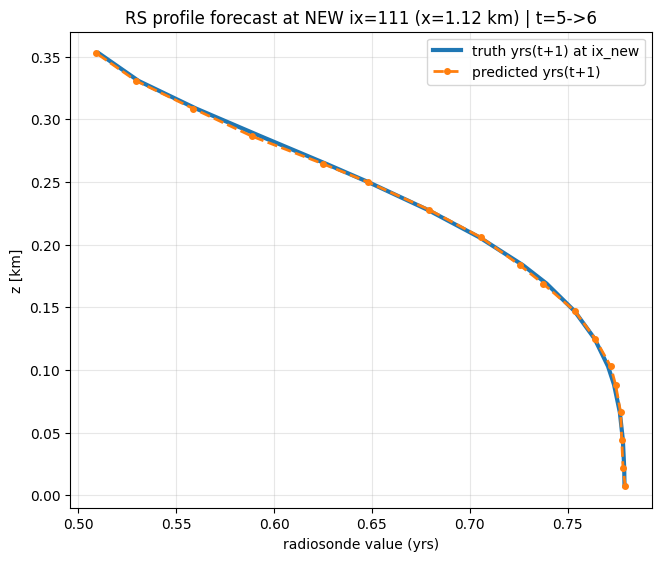

Saved: rs_rec/rs_profile_pred_truth_ix111_t05_to_06.png
Profile RMSE (physical): 0.001454
RS input used from yrs[t] at stations rs_ix: [0, 21, 43, 64, 86, 107, 129]
Query ix_new: 111 (x=1.12 km)


In [14]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# ============================================================
# Visualization: RS profile forecast at manually chosen NEW x
# RS INPUT comes from saved yrs[t] (NOT from xtrue sampling!)
# saves to: rs_rec/rs_profile_pred_truth_ixXXX_tTT_to_TT1.png
# ============================================================

# -----------------------------
# USER CONTROLS
# -----------------------------
t = 5                          # snapshot index (0..T-2)
ix_new = 111                   # <-- MANUAL: choose x index here (0..nx-1)
require_unseen = True          # True: forbid ix_new in original rs_ix
outdir = "rs_rec"              # output folder
# -----------------------------

os.makedirs(outdir, exist_ok=True)

# --- sanity checks ---
assert 0 <= t <= T-2, f"t must be in [0, {T-2}] but is {t}"
assert 0 <= ix_new <= nx-1, f"ix_new must be in [0, {nx-1}] but is {ix_new}"

rs_ix_old = set(int(v) for v in rs_ix.tolist())
if require_unseen and (ix_new in rs_ix_old):
    raise ValueError(
        f"ix_new={ix_new} is one of the original radiosonde x-columns rs_ix={sorted(rs_ix_old)}.\n"
        f"Either set require_unseen=False or choose another ix_new."
    )

# ------------------------------------------------------------
# Build RS input set from SAVED DATA yrs[t]
# rs locations are (rs_ix, rs_iz) fixed network
# ------------------------------------------------------------
# yrs shape: (time, station, vert)
# rs_ix shape: (station,)
# rs_iz shape: (vert,)

nrs_in = int(len(rs_ix))
nvert_in = int(len(rs_iz))

pts = []
for irs in range(nrs_in):
    ix0 = int(rs_ix[irs])
    x0n = ix0 / (nx - 1)

    for iv in range(nvert_in):
        iz0 = int(rs_iz[iv])
        z0n = iz0 / (nz - 1)

        val_phys = float(yrs[t, irs, iv])  # <-- from saved radiosonde obs
        # normalize RS value for network
        val_n = (val_phys - xtrue_mu) / xtrue_sd
        pts.append([x0n, z0n, val_n])

rs_in = np.asarray(pts, dtype=np.float32)          # (Nin,3)
mask_in = np.ones((rs_in.shape[0],), dtype=np.float32)

# ------------------------------------------------------------
# Query vertical profile at the manually chosen ix_new
# ------------------------------------------------------------
# Use the same number of vertical points as radiosonde network for nicer plot
# (you can switch back to nvert_q if you prefer)
iz_prof = np.array(rs_iz, dtype=int)               # (18,)
q_xy = np.stack([
    np.full(len(iz_prof), ix_new/(nx-1), dtype=np.float32),
    (iz_prof/(nz-1)).astype(np.float32)
], axis=1)

# truth RS at t+1 (normalized) taken from xtrue (verification target)
rs_true_n = xtrue_n[t+1, iz_prof, ix_new]          # (18,)

# ------------------------------------------------------------
# Predict RS profile with trained model
# ------------------------------------------------------------
model.eval()
with torch.no_grad():
    x_sat = torch.tensor(ysat_n[t][None, ...], dtype=torch.float32, device=device)

    rs_pts = torch.tensor(rs_in[None, ...], dtype=torch.float32, device=device)
    mask_in_t = torch.tensor(mask_in[None, ...], dtype=torch.float32, device=device)

    q_xy_t = torch.tensor(q_xy[None, ...], dtype=torch.float32, device=device)

    _, yrs_pred = model(x_sat, rs_pts, mask_in_t, q_xy_t)
    yrs_pred = yrs_pred[0].detach().cpu().numpy()  # (18,)

# de-normalize to physical
rs_true = rs_true_n * xtrue_sd + xtrue_mu
rs_pred = yrs_pred  * xtrue_sd + xtrue_mu

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
z_km = z[iz_prof] / 1000.0
x_km_val = x[ix_new] / 1000.0

fig, ax = plt.subplots(1, 1, figsize=(6.5, 5.5), constrained_layout=True)
ax.plot(rs_true, z_km, lw=3, label="truth yrs(t+1) at ix_new")
ax.plot(rs_pred, z_km, lw=2, ls="--", marker="o", ms=4, label="predicted yrs(t+1)")

ax.set_xlabel("radiosonde value (yrs)")
ax.set_ylabel("z [km]")
ax.set_title(f"RS profile forecast at NEW ix={ix_new} (x={x_km_val:.2f} km) | t={t}->{t+1}")
ax.grid(True, alpha=0.3)
ax.legend(loc="best")

rmse_prof = float(np.sqrt(np.mean((rs_pred - rs_true)**2)))

fname = f"rs_profile_pred_truth_ix{ix_new:03d}_t{t:02d}_to_{t+1:02d}.png"
fpath = os.path.join(outdir, fname)
fig.savefig(fpath, dpi=180)
plt.show()

print("Saved:", fpath)
print(f"Profile RMSE (physical): {rmse_prof:.6f}")
print("RS input used from yrs[t] at stations rs_ix:", rs_ix.astype(int).tolist())
print("Query ix_new:", ix_new, f"(x={x_km_val:.2f} km)")


Querying full grid points: 6500 = 50 * 130
Field metrics (physical): RMSE=0.002996, MAE=0.002236


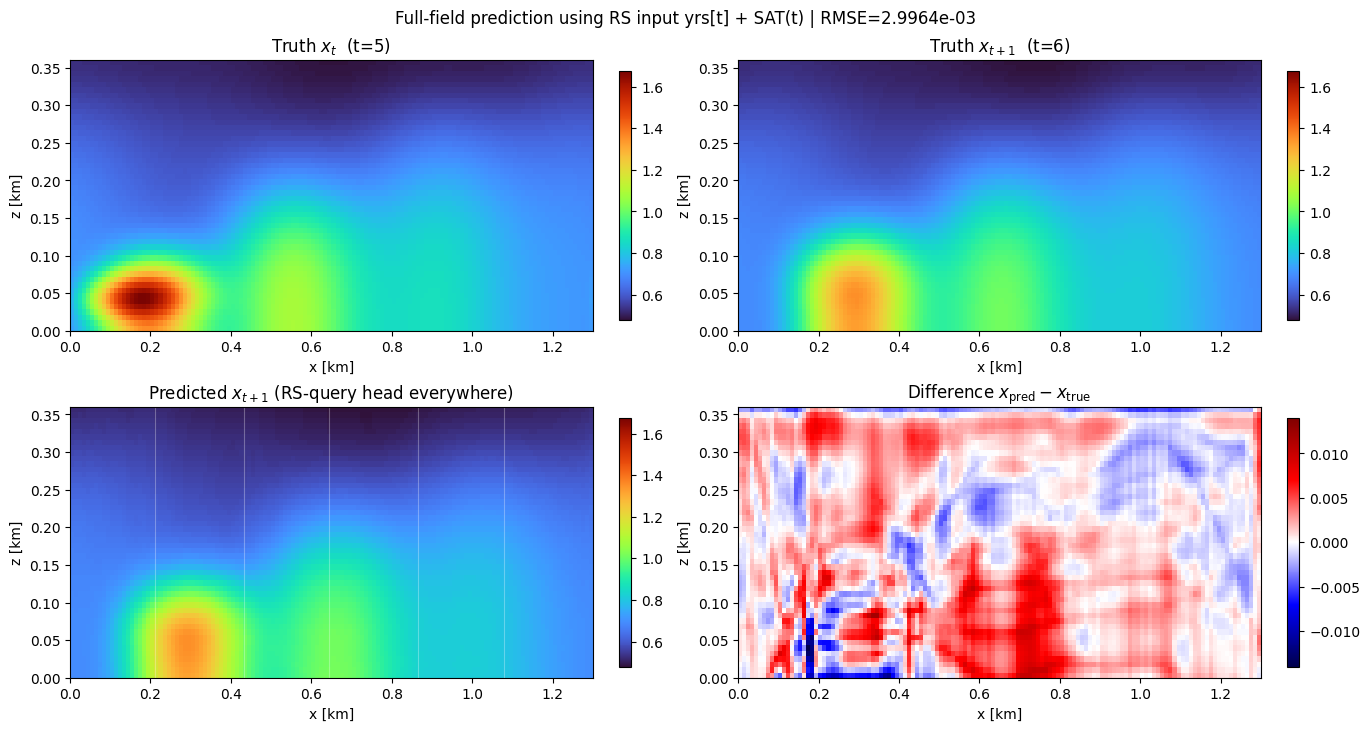

Saved: rs_rec/xpred_full_2x2_t05_to_06.png


In [15]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# ============================================================
# Cell: Predict full 2D field at t+1 using RS-query head at ALL grid points
# + 2x2 plot: xtrue[t], xtrue[t+1], xpred[t+1], diff
# Saves: rs_rec/xpred_full_2x2_tTT_to_TT1.png
# ============================================================

# -----------------------------
# USER CONTROLS
# -----------------------------
t = 5                    # snapshot index (0..T-2)
outdir = "rs_rec"
prefix = "xpred_full_2x2"
chunk_nq = 2048           # number of query points per forward pass (safe for MPS/CPU)
# -----------------------------

os.makedirs(outdir, exist_ok=True)
assert 0 <= t <= T-2, f"t must be in [0,{T-2}] but is {t}"

# ------------------------------------------------------------
# 1) Build RS input set from SAVED DATA yrs[t]
# ------------------------------------------------------------
nrs_in = int(len(rs_ix))
nvert_in = int(len(rs_iz))

pts = []
for irs in range(nrs_in):
    ix0 = int(rs_ix[irs])
    x0n = ix0 / (nx - 1)
    for iv in range(nvert_in):
        iz0 = int(rs_iz[iv])
        z0n = iz0 / (nz - 1)

        val_phys = float(yrs[t, irs, iv])                 # from saved radiosonde obs
        val_n = (val_phys - xtrue_mu) / xtrue_sd          # normalize for network
        pts.append([x0n, z0n, val_n])

rs_in = np.asarray(pts, dtype=np.float32)                # (Nin,3)
mask_in = np.ones((rs_in.shape[0],), dtype=np.float32)

# ------------------------------------------------------------
# 2) Build query set for ALL grid points (x,z)
# ------------------------------------------------------------
x_norm = np.linspace(0.0, 1.0, nx, dtype=np.float32)
z_norm = np.linspace(0.0, 1.0, nz, dtype=np.float32)
Zg, Xg = np.meshgrid(z_norm, x_norm, indexing="ij")      # (nz,nx)

q_all = np.stack([Xg.reshape(-1), Zg.reshape(-1)], axis=1).astype(np.float32)  # (nz*nx,2)
Nq_all = q_all.shape[0]
print("Querying full grid points:", Nq_all, "=", nz, "*", nx)

# ------------------------------------------------------------
# 3) Predict xpred at t+1 at all query points (chunked)
# ------------------------------------------------------------
model.eval()
with torch.no_grad():
    x_sat = torch.tensor(ysat_n[t][None, ...], dtype=torch.float32, device=device)  # (1,nsat,nx)
    rs_pts = torch.tensor(rs_in[None, ...], dtype=torch.float32, device=device)     # (1,Nin,3)
    mask_in_t = torch.tensor(mask_in[None, ...], dtype=torch.float32, device=device)

    pred_list = []
    for i0 in range(0, Nq_all, chunk_nq):
        i1 = min(Nq_all, i0 + chunk_nq)
        q_chunk = q_all[i0:i1]                                                     # (Nc,2)
        q_xy_t = torch.tensor(q_chunk[None, ...], dtype=torch.float32, device=device)  # (1,Nc,2)

        _, yrs_pred = model(x_sat, rs_pts, mask_in_t, q_xy_t)                      # (1,Nc)
        pred_list.append(yrs_pred[0].detach().cpu().numpy())

    yrs_pred_all_n = np.concatenate(pred_list, axis=0)                             # (nz*nx,)

# reshape to full field, de-normalize
xpred = (yrs_pred_all_n.reshape(nz, nx) * xtrue_sd + xtrue_mu).astype(np.float64)

# ------------------------------------------------------------
# 4) Truth fields + difference
# ------------------------------------------------------------
xtrue_t    = xtrue[t].astype(np.float64)
xtrue_next = xtrue[t+1].astype(np.float64)
xdiff = xpred - xtrue_next

rmse_field = float(np.sqrt(np.mean((xpred - xtrue_next)**2)))
mae_field  = float(np.mean(np.abs(xpred - xtrue_next)))
print(f"Field metrics (physical): RMSE={rmse_field:.6f}, MAE={mae_field:.6f}")

# ------------------------------------------------------------
# 5) Plot 2x2: xtrue[t], xtrue[t+1], xpred[t+1], diff
# ------------------------------------------------------------
x_km = x / 1000.0
z_km = z / 1000.0

vmin = float(min(xtrue_t.min(), xtrue_next.min(), xpred.min()))
vmax = float(max(xtrue_t.max(), xtrue_next.max(), xpred.max()))
norm_main = Normalize(vmin=vmin, vmax=vmax)

dmax = float(np.max(np.abs(xdiff)) + 1e-12)
norm_diff = Normalize(vmin=-dmax, vmax=dmax)

fig, axes = plt.subplots(2, 2, figsize=(13.6, 7.2), constrained_layout=True)
(ax00, ax01), (ax10, ax11) = axes

# --- xtrue[t] ---
im00 = ax00.imshow(xtrue_t, origin="lower",
                   extent=[x_km.min(), x_km.max(), z_km.min(), z_km.max()],
                   aspect="auto", cmap="turbo", norm=norm_main)
ax00.set_title(f"Truth $x_t$  (t={t})")
ax00.set_xlabel("x [km]")
ax00.set_ylabel("z [km]")
fig.colorbar(im00, ax=ax00, shrink=0.92)

# --- xtrue[t+1] ---
im01 = ax01.imshow(xtrue_next, origin="lower",
                   extent=[x_km.min(), x_km.max(), z_km.min(), z_km.max()],
                   aspect="auto", cmap="turbo", norm=norm_main)
ax01.set_title(f"Truth $x_{{t+1}}$  (t={t+1})")
ax01.set_xlabel("x [km]")
ax01.set_ylabel("z [km]")
fig.colorbar(im01, ax=ax01, shrink=0.92)

# --- xpred[t+1] ---
im10 = ax10.imshow(xpred, origin="lower",
                   extent=[x_km.min(), x_km.max(), z_km.min(), z_km.max()],
                   aspect="auto", cmap="turbo", norm=norm_main)
ax10.set_title(r"Predicted $x_{t+1}$ (RS-query head everywhere)")
ax10.set_xlabel("x [km]")
ax10.set_ylabel("z [km]")
# show RS station x-locations
for irs in range(nrs_in):
    ax10.axvline(x_km[int(rs_ix[irs])], color="white", lw=0.8, alpha=0.30)
fig.colorbar(im10, ax=ax10, shrink=0.92)

# --- diff ---
im11 = ax11.imshow(xdiff, origin="lower",
                   extent=[x_km.min(), x_km.max(), z_km.min(), z_km.max()],
                   aspect="auto", cmap="seismic", norm=norm_diff)
ax11.set_title(r"Difference $x_{\mathrm{pred}}-x_{\mathrm{true}}$")
ax11.set_xlabel("x [km]")
ax11.set_ylabel("z [km]")
fig.colorbar(im11, ax=ax11, shrink=0.92)

fig.suptitle(
    f"Full-field prediction using RS input yrs[t] + SAT(t) | RMSE={rmse_field:.4e}",
    fontsize=12
)

# ------------------------------------------------------------
# 6) Save
# ------------------------------------------------------------
fname = f"{prefix}_t{t:02d}_to_{t+1:02d}.png"
fpath = os.path.join(outdir, fname)
fig.savefig(fpath, dpi=180)
plt.show()

print("Saved:", fpath)
